# Deep learning basics: a simple regression case
In this tutorial, we train a Multi Layer Perceptron (MLP) to fit a noisy sinusoid curve.

## Step 1: Prepare the environment

In [ ]:
import torch
import numpy as np
import plotly.express as px
import pandas as pd
from utils import plot_sin_predictions

In [ ]:
# Define computing device
use_cuda = True

if torch.cuda.is_available() and use_cuda:
    print('We have GPU !')
    device = torch.device('cuda')
else:
    print('We will use CPU')
    device = torch.device('cpu')

In [ ]:
# Fix random seed for reproducibility
torch.manual_seed(0)

## Step 2: Generate training data

In [ ]:
# Training data
x = torch.linspace(-10, 10, 1000).unsqueeze(1).to(device)
# Label
y = torch.sin(x) + 0.2 * torch.rand_like(x)

In [ ]:
training_data = pd.DataFrame({
    'x': x.squeeze(1).to('cpu'),
    'y': y.squeeze(1).to('cpu')
})

In [ ]:
px.scatter(training_data, x='x', y='y')

## Step 3: Build the neural network

We build a MLP, i.e., composed of Fully Connected layers, with 2 hidden layers.

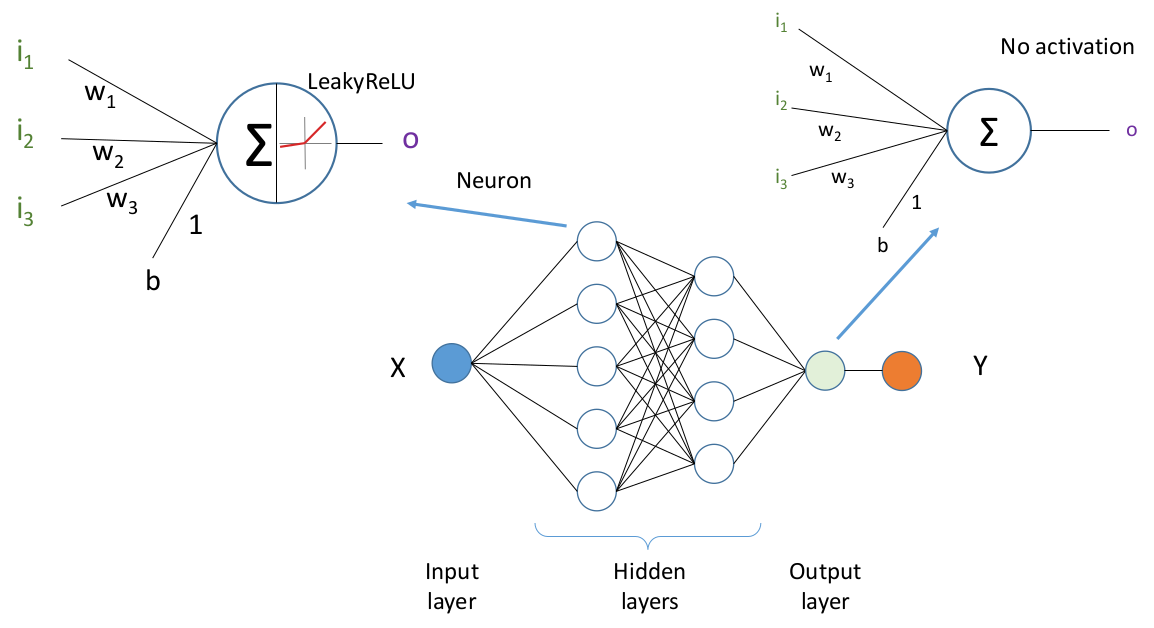

In [ ]:
# Fix random seed for reproducibility
torch.manual_seed(0)

In [ ]:
neurons_lin1 = 200
neurons_lin2 = 100

model = torch.nn.Sequential(
    # hidden layers
    torch.nn.Linear(in_features=x.shape[1], out_features=neurons_lin1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(in_features=neurons_lin1, out_features=neurons_lin2),
    torch.nn.LeakyReLU(),
    # output layers
    torch.nn.Linear(in_features=neurons_lin2, out_features=y.shape[1])
)

model.to(device)

## Step 4: Define training hyperparameters

In [ ]:
# Loss function
criterion = torch.nn.MSELoss()

### Exercise
Tweak the learning rate to improve the performance of the model

In [ ]:
learning_rate = 0.5

In [ ]:
# Optimizer (Gradient descent)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training duration
num_epochs = 500

## Step 5: Train the network

In [ ]:
predictions = []
losses = []

for epoch in range(num_epochs):
    # Reinitialize gradient of the model weights
    optimizer.zero_grad()
    
    # Prediction
    y_pred = model(x)
    
    # Error measurement
    loss = criterion(y_pred, y)
    
    # Backpropagation
    loss.backward()
    
    # Weight update
    optimizer.step()
#     scheduler.step()
    
    predictions.append(y_pred.detach().to('cpu'))
    losses.append(loss.detach().to('cpu'))

### Training results

In [ ]:
training_loss = pd.DataFrame({
    'Epoch': range(len(losses)),
    'Loss': losses
})

In [ ]:
fig = px.line(training_loss, x='Epoch', y='Loss', title='Training loss')
fig.show()

In [ ]:
plot_sin_predictions(training_data, predictions)

## Step 6: Test the model on new data

In [ ]:
# Test data
x_test = torch.linspace(-10, 10, 1500).unsqueeze(1).to(device)
# Label
y_test = torch.sin(x_test) + 0.2 * torch.rand_like(x_test)

In [ ]:
# Switch the model to test mode
# This is important for some kinds of layers, such as BatchNorm, that have 
# different behavior at test and training time
model.eval()

# We don't need to build the gradient graph, so let's save some memory !
with torch.no_grad():
    y_pred_test = model(x_test)
    test_loss = criterion(y_pred_test, y_test)

In [ ]:
test_results = pd.DataFrame(
    {
        'x': x_test.to('cpu').flatten(),
        'y': y_test.to('cpu').flatten(),
        'y_pred': y_pred_test.to('cpu').flatten()
    }
)

In [ ]:
fig = px.scatter(test_results, x='x', y=['y', 'y_pred'],
                title='Test results. Test loss: {:0.4f}'.format(test_loss))
fig.update_traces(marker={'size': 3})
fig.show()

## Do you need a "solution" ?
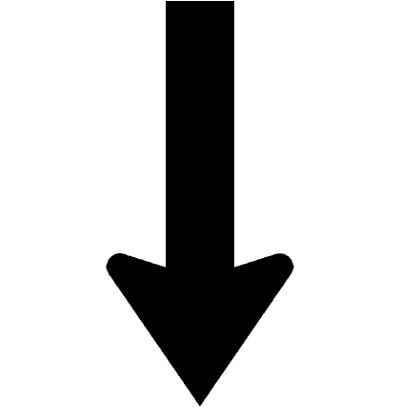

### Hint

You can explore learning rates in the range [0.1 ; 0.001]

### Solution
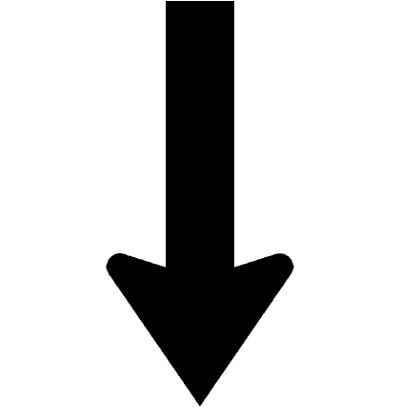

In [ ]:
# Quite good parameter
learning_rate = 0.05

### A step further !

To go further, you can decrease the learning rate during training. For instance:
1. Declare a learning rate scheduler right after the optimizer
```python
optimizer = ...
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.5)
```
2. In the training loop, call the step function of the scheduler
```python
optimizer.step()
scheduler.step()
```